In [1]:
with open('./function/requirements_import.py') as f:
    exec(f.read())
    
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler


In [2]:
file_path = './data/'
rainfall = pd.read_csv(file_path + 'rainfall_train_v3.csv')

es = EarlyStopping(monitor='val_loss',        # 얼리스토핑을 적용할 관측 지표
                min_delta=0,               # 임계값
                patience=5,                # 성능 개선이 발생하지 않았을 때, 몇 epochs 더 지켜볼 것인지
                verbose=0,                 # 몇 번째 epochs에서 얼리스토핑이 되었는가 알려줌
                restore_best_weights=True  # 최적의 가중치를 가진 epoch 시점으로 가중치를 되돌림
                )

In [3]:
# 종속변수
target = 'class_interval'

# x, y
x = rainfall.drop(columns=[target, 'fc_year', 'stn4contest', 'pred_YN'])

y = rainfall.loc[:, target]

# GAF : 시계열 -> 이미지
gaf = GramianAngularField(method='summation')
x_gaf = gaf.fit_transform(x)
x_gaf4 = x_gaf.reshape(-1, x.shape[1], x.shape[1], 1)


# 각 범주의 최소 데이터 수 찾기
ind_class = [np.where(y == i)[0] for i in range(10)]
min_samples = min(len(indices) for indices in ind_class)

# 각 범주에서 최소 데이터 수만큼 랜덤 샘플 추출
bal_ind = np.hstack([np.random.choice(indices, min_samples, replace=False) for indices in ind_class])

# 추출한 인덱스로 데이터와 레이블 준비
bal_x = x_gaf4[bal_ind]
bal_y = y[bal_ind]

# 7:1.7:1.3 데이터로 분할
x_train, x_test, y_train, y_test = train_test_split(bal_x, bal_y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.4, random_state=42)

print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(48713, 29, 29, 1) (12526, 29, 29, 1) (8351, 29, 29, 1)
(48713,) (12526,) (8351,)


In [4]:
# 업샘플링 초기화
ros = RandomOverSampler(random_state=42)

# 학습용 데이터에 대해 업샘플링 적용
x_train_res, y_train_res = ros.fit_resample(x_train.reshape(x_train.shape[0], -1), y_train)
x_train_res = x_train_res.reshape(x_train_res.shape[0], x_train.shape[1], x_train.shape[2], 1)
print(x_train_res.shape)
print('-'*150)
print(y_train_res.value_counts())

(49150, 29, 29, 1)
------------------------------------------------------------------------------------------------------------------------------------------------------
class_interval
0.0    4915
4.0    4915
3.0    4915
8.0    4915
5.0    4915
9.0    4915
1.0    4915
7.0    4915
2.0    4915
6.0    4915
Name: count, dtype: int64


In [ ]:
# 0610_18:00기준 best
clear_session()

model = Sequential([Rescaling(1/255, input_shape=x_train_res.shape[1:]), # input_shape=(32, 32, 3)
                    Conv2D(64, kernel_size = 3, strides=(1,1), padding='same', activation='relu'),
                    MaxPooling2D(pool_size = 2 ),
                    Flatten(),
                    Dense(256, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(10, activation='softmax')])


model.summary()

# 모델 설정
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_sch = LearningRateScheduler(scheduler)

# 학습
history = model.fit(x_train_res, y_train_res, epochs = 300, callbacks=[lr_sch, es], validation_data=(x_val, y_val), batch_size=64).history

# 예측
pred = model.predict(x_test)
pred_1 = pred.argmax(axis=1)

cm = confusion_matrix(y_test, pred_1)
print(csi(cm))
print('-'*60)
print(cm)
print('-'*60)
print(classification_report(y_test, pred_1))

beepsound()

In [24]:
model.save('./data/epoch100.keras')

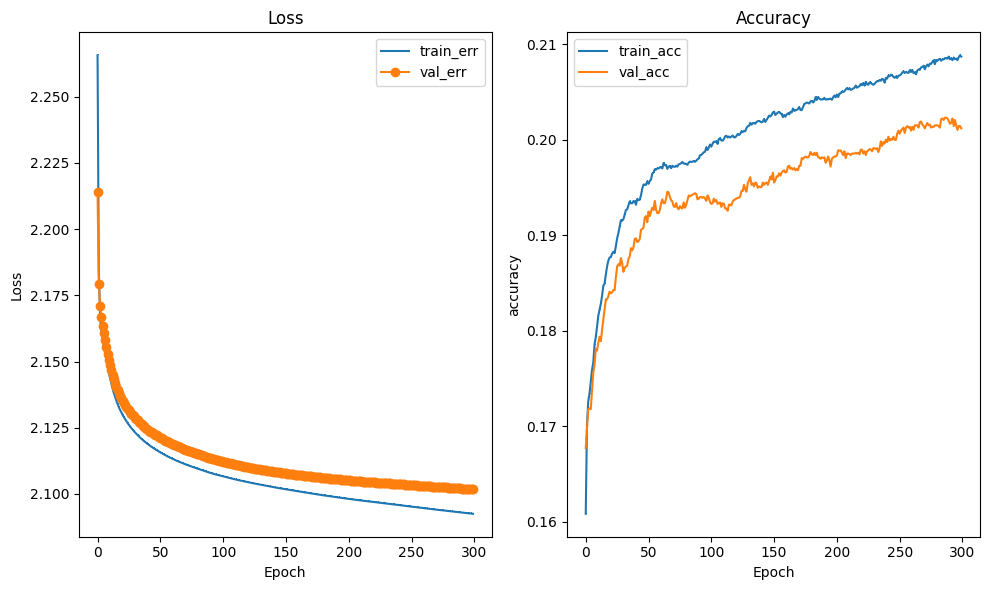

In [23]:
### 학습곡선 (loss)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='train_err', marker = ',')
plt.plot(history['val_loss'], label='val_err', marker = 'o')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Loss')

### 학습곡선 (Accuracy)
plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='train_acc', marker = ',')
plt.plot(history['val_accuracy'], label='val_acc', marker = 'o')

plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

In [25]:
history = model.fit(x_train_res, y_train_res, epochs = 800, callbacks=[lr_sch, es], validation_data=(x_val, y_val), batch_size=64).history

Epoch 1/800
768/768 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.2129 - loss: 2.0847 - val_accuracy: 0.2021 - val_loss: 2.1018 - learning_rate: 1.2110e-05
Epoch 2/800
768/768 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.2135 - loss: 2.0845 - val_accuracy: 0.2013 - val_loss: 2.1017 - learning_rate: 1.0958e-05
Epoch 3/800
768/768 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.2133 - loss: 2.0844 - val_accuracy: 0.2013 - val_loss: 2.1017 - learning_rate: 1.0849e-05
Epoch 4/800
768/768 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.2134 - loss: 2.0844 - val_accuracy: 0.2015 - val_loss: 2.1017 - learning_rate: 1.0838e-05
Epoch 5/800
768/768 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.2133 - loss: 2.0844 - val_accuracy: 0.2016 - val_loss: 2.1017 - learning_rate: 1.0837e-05
Epoch 6/800
768/768 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.2136 - loss: 2.0843 - val_accuracy: 0.2018 - val_loss: 2.1017 - learning_rate: 1.0837e-05
Epoch 7/800
768/768 ━━━━━━━━━━━━━━━━━━━━ 15s 2

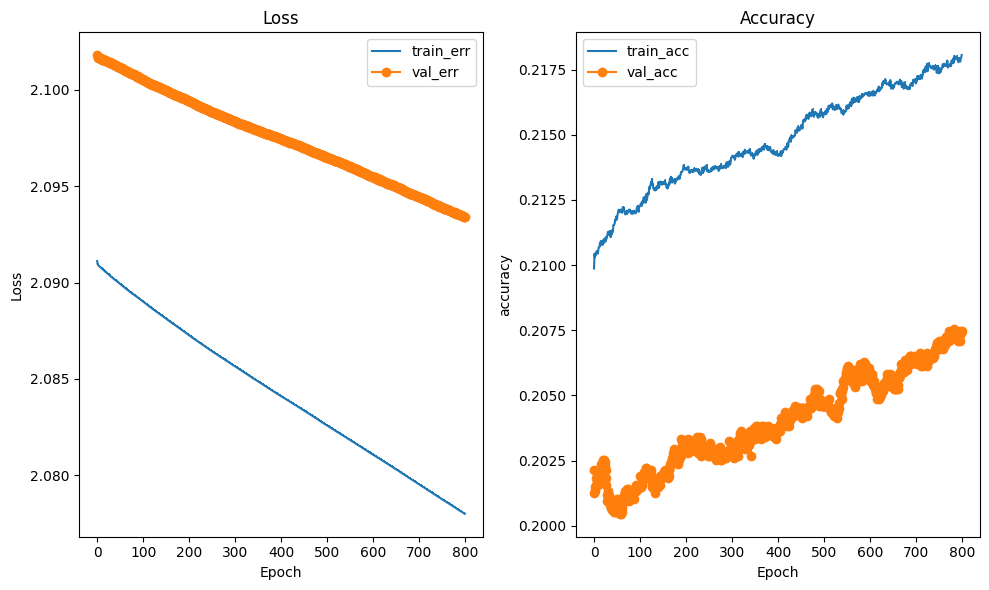

In [26]:
### 학습곡선 (loss)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='train_err', marker = ',')
plt.plot(history['val_loss'], label='val_err', marker = 'o')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Loss')

### 학습곡선 (Accuracy)
plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='train_acc', marker = ',')
plt.plot(history['val_accuracy'], label='val_acc', marker = 'o')

plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

In [27]:
model.save(file_path + 'epoch200.keras')

In [9]:
model = tf.keras.models.load_model(file_path + 'epoch200.keras')
history = model.fit(x_train_res, y_train_res, epochs = 800, callbacks=[lr_sch, es], validation_data=(x_val, y_val), batch_size=64).history

Epoch 1/800
768/768 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.2204 - loss: 2.0710 - val_accuracy: 0.2080 - val_loss: 2.0927 - learning_rate: 3.9866e-06
Epoch 2/800
768/768 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.2211 - loss: 2.0706 - val_accuracy: 0.2076 - val_loss: 2.0927 - learning_rate: 3.6073e-06
Epoch 3/800
768/768 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.2213 - loss: 2.0706 - val_accuracy: 0.2079 - val_loss: 2.0927 - learning_rate: 3.5714e-06
Epoch 4/800
768/768 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.2216 - loss: 2.0706 - val_accuracy: 0.2080 - val_loss: 2.0927 - learning_rate: 3.5678e-06
Epoch 5/800
768/768 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.2217 - loss: 2.0706 - val_accuracy: 0.2077 - val_loss: 2.0927 - learning_rate: 3.5674e-06


-----

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM
# 종속변수
target = 'class_interval'

# x, y
x_pre = rainfall.drop(columns=[target, 'fc_year', 'stn4contest', 'pred_YN'])
x = pad_sequences(x_pre.values, maxlen=80)
y = rainfall.loc[:, target].astype(int)

aa, bb = idx_find(x_pre)

# 7:1.7:1.3 데이터로 분할
x_train = x[:aa+1]
y_train = y.iloc[:aa+1]

x_val = x[aa+1:bb+1]
y_val = y.iloc[aa+1:bb+1]

x_test = x[bb+1:]
y_test = y.iloc[bb+1:]
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(871520, 80) (363120, 80) (218080, 80)
(871520,) (363120,) (218080,)


In [56]:
clear_session()

model = Sequential([
    LSTM(32, input_shape=(80, 1), activation='tanh'),
    Dropout(0.5),
    # LSTM(32, activation='tanh'),
    # Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(10, activation='softmax')
])

model.summary()

# 모델 설정
model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy', csi_metric])


# lr_sch = LearningRateScheduler(scheduler)

# 학습
history = model.fit(x_train, y_train, epochs = 300, callbacks=[es], validation_data=(x_val, y_val), batch_size=64).history #lr_sch, 

# 예측
pred = model.predict(x_test)
pred_1 = pred.argmax(axis=1)

cm = confusion_matrix(y_test, pred_1)
print(csi(cm))
print('-'*60)
print(cm)
print('-'*60)
print(classification_report(y_test, pred_1))

# beepsound()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,050 (19.73 KB)

 Trainable params: 5,050 (19.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
13618/13618 ━━━━━━━━━━━━━━━━━━━━ 252s 18ms/step - accuracy: 0.8296 - csi_metric: 7.9128e-04 - loss: 0.7088 - val_accuracy: 0.8451 - val_csi_metric: 3.9024e-04 - val_loss: 0.6438
Epoch 2/300
13618/13618 ━━━━━━━━━━━━━━━━━━━━ 263s 19ms/step - accuracy: 0.8307 - csi_metric: 0.0013 - loss: 0.6914 - val_accuracy: 0.8458 - val_csi_metric: 9.5963e-04 - val_loss: 0.6420
Epoch 3/300
13618/13618 ━━━━━━━━━━━━━━━━━━━━ 312s 19ms/step - accuracy: 0.8306 - csi_metric: 0.0013 - loss: 0.6903 - val_accuracy: 0.8453 - val_csi_metric: 5.1392e-04 - val_loss: 0.6478
Epoch 4/300
13618/13618 ━━━━━━━━━━━━━━━━━━━━ 266s 20ms/step - accuracy: 0.8306 - csi_metric: 0.0012 - loss: 0.6906 - val_accuracy: 0.8454 - val_csi_metric: 6.1506e-04 - val_loss: 0.6485
Epoch 5/300
13618/13618 ━━━━━━━━━━━━━━━━━━━━ 268s 20ms/step - accuracy: 0.8306 - csi_metric: 0.0012 - loss: 0.6898 - val_accuracy: 0.8452 - val_csi_metric: 4.7895e-04 - val_loss: 0.6519
6815/6815 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step
0.0002147755839211188


In [8]:
from keras.layers import GRU

In [10]:
clear_session()

model = Sequential([
    GRU(64, input_shape=(80, 1), activation='sigmoid', return_sequences=True),
    Dropout(0.3),
    GRU(32, activation='sigmoid', return_sequences=True),
    Dropout(0.3),
    GRU(32, activation='tanh'),
    Dropout(0.3),
    # Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(10, activation='softmax')
])

model.summary()

# 모델 설정
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy', csi_metric])

# lr_sch = LearningRateScheduler(scheduler)

es = EarlyStopping(monitor='val_loss',        # 얼리스토핑을 적용할 관측 지표
                min_delta=0,               # 임계값
                patience=5,                # 성능 개선이 발생하지 않았을 때, 몇 epochs 더 지켜볼 것인지
                verbose=0,                 # 몇 번째 epochs에서 얼리스토핑이 되었는가 알려줌
                restore_best_weights=True  # 최적의 가중치를 가진 epoch 시점으로 가중치를 되돌림
                )

# 학습
history = model.fit(x_train, y_train, epochs = 300, callbacks=[es], validation_data=(x_val, y_val), batch_size=64).history #lr_sch, 

# 예측
pred = model.predict(x_test)
pred_1 = pred.argmax(axis=1)

cm = confusion_matrix(y_test, pred_1)
print(csi(cm))
print('-'*60)
print(cm)
print('-'*60)
print(classification_report(y_test, pred_1))

# beepsound()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 80, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 80, 32)         │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 80, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,362 (118.60 KB)

 Trainable params: 30,362 (118.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
11078/13618 ━━━━━━━━━━━━━━━━━━━━ 4:46 113ms/step - accuracy: 0.8271 - csi_metric: 7.0348e-04 - loss: 0.7289

KeyboardInterrupt: 

In [ ]:
### 학습곡선 (loss)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='train_err', marker = ',')
plt.plot(history['val_loss'], label='val_err', marker = 'o')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Loss')

### 학습곡선 (Accuracy)
plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='train_acc', marker = ',')
plt.plot(history['val_accuracy'], label='val_acc', marker = 'o')

plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

-----

In [12]:
# 종속변수
target = 'class_interval'

# x, y
x = rainfall.drop(columns=[target, 'fc_year', 'stn4contest', 'pred_YN'])
y = rainfall.loc[:, target]

# GAF : 시계열 -> 이미지
gaf = GramianAngularField(method='summation')
x_gaf = gaf.fit_transform(x)
x_gaf4 = x_gaf.reshape(-1, x.shape[1], x.shape[1], 1)

# 각 범주의 최소 데이터 수 찾기
ind_class = [np.where(y == i)[0] for i in range(10)]
min_samples = min(len(indices) for indices in ind_class)

# 각 범주에서 최소 데이터 수만큼 랜덤 샘플 추출
bal_ind = np.hstack([np.random.choice(indices, min_samples, replace=False) for indices in ind_class])

# 추출한 인덱스로 데이터와 레이블 준비
bal_x = x_gaf4[bal_ind]
bal_y = y[bal_ind]

# 7:1.7:1.3 데이터로 분할
x_train, x_test, y_train, y_test = train_test_split(bal_x, bal_y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.4, random_state=42)

print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(48713, 29, 29, 1) (12526, 29, 29, 1) (8351, 29, 29, 1)
(48713,) (12526,) (8351,)


In [14]:
# 업샘플링 초기화
ros = RandomOverSampler(random_state=42)

# 학습용 데이터에 대해 업샘플링 적용
x_train_res, y_train_res = ros.fit_resample(x_train.reshape(x_train.shape[0], -1), y_train)
x_train_res = x_train_res.reshape(x_train_res.shape[0], x_train.shape[1], x_train.shape[2], 1)
print(x_train_res.shape)
print('-'*150)
print(y_train_res.value_counts())

(49150, 29, 29, 1)
------------------------------------------------------------------------------------------------------------------------------------------------------
class_interval
0.0    4915
4.0    4915
3.0    4915
8.0    4915
5.0    4915
9.0    4915
1.0    4915
7.0    4915
2.0    4915
6.0    4915
Name: count, dtype: int64


In [18]:
from tensorflow.keras import layers, models, Model, Input

In [43]:
from tensorflow.keras import Model, Input
clear_session()

cnn_model = models.Sequential([Rescaling(1/255, input_shape=x_train_res.shape[1:]), # input_shape=(32, 32, 3)
                    Conv2D(29, kernel_size = 3, strides=(1,1), padding='same', activation='relu'),
                    MaxPooling2D(pool_size = 2 ),
                    Conv2D(64, kernel_size = 3, strides=(1,1), padding='same', activation='relu'),
                    MaxPooling2D(pool_size = 2 ),
                    Flatten()])

# 입력 정의
input_layer = Input(shape=x_train_res.shape[1:])

# CNN 모델을 통해 특징 추출
cnn_features = cnn_model(input_layer)

# CNN 출력 reshape
output_shape = cnn_model.output_shape[-1]
cnn_features_reshaped = layers.Reshape((1, output_shape))(cnn_features)  # GRU 입력 형태에 맞추기 위해 reshape

# GRU 모델을 통해 분류
gru_model = models.Sequential([
    layers.GRU(32, return_sequences=True, input_shape=(None, 3136)),
    layers.GRU(16),
    layers.Dense(10, activation='softmax')  # 이진 분류 예제
])

output_layer = gru_model(cnn_features_reshaped)

# 전체 모델 정의
model = Model(inputs=input_layer, outputs=output_layer)

In [44]:
model.summary()

# 모델 설정
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy', csi_metric])

es = EarlyStopping(monitor='val_loss',        # 얼리스토핑을 적용할 관측 지표
                min_delta=0,               # 임계값
                patience=5,                # 성능 개선이 발생하지 않았을 때, 몇 epochs 더 지켜볼 것인지
                verbose=0,                 # 몇 번째 epochs에서 얼리스토핑이 되었는가 알려줌
                restore_best_weights=True  # 최적의 가중치를 가진 epoch 시점으로 가중치를 되돌림
                )
# 학습
history = model.fit(x_train_res, y_train_res, epochs = 300, callbacks=[es], validation_data=(x_val, y_val), batch_size=64).history #lr_sch, 

# 예측
pred = model.predict(x_test)
pred_1 = pred.argmax(axis=1)

cm = confusion_matrix(y_test, pred_1)
print(csi(cm))
print('-'*60)
print(cm)
print('-'*60)
print(classification_report(y_test, pred_1))

beepsound()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 29, 29, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 3136)           │        17,058 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 3136)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 10)             │       306,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,948 (1.24 MB)

 Trainable params: 323,948 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
768/768 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.1275 - csi_metric: 0.0814 - loss: 2.2841 - val_accuracy: 0.1716 - val_csi_metric: 0.1002 - val_loss: 2.1893
Epoch 2/300
768/768 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.1766 - csi_metric: 0.0970 - loss: 2.1762 - val_accuracy: 0.1702 - val_csi_metric: 0.1053 - val_loss: 2.1772
Epoch 3/300
768/768 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.1775 - csi_metric: 0.1010 - loss: 2.1658 - val_accuracy: 0.1714 - val_csi_metric: 0.1077 - val_loss: 2.1704
Epoch 4/300
768/768 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.1779 - csi_metric: 0.1035 - loss: 2.1588 - val_accuracy: 0.1724 - val_csi_metric: 0.1090 - val_loss: 2.1632
Epoch 5/300
768/768 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.1814 - csi_metric: 0.1076 - loss: 2.1514 - val_accuracy: 0.1772 - val_csi_metric: 0.1137 - val_loss: 2.1556
Epoch 6/300
768/768 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.1833 - csi_metric: 0.1099 - loss: 2.1443 - val

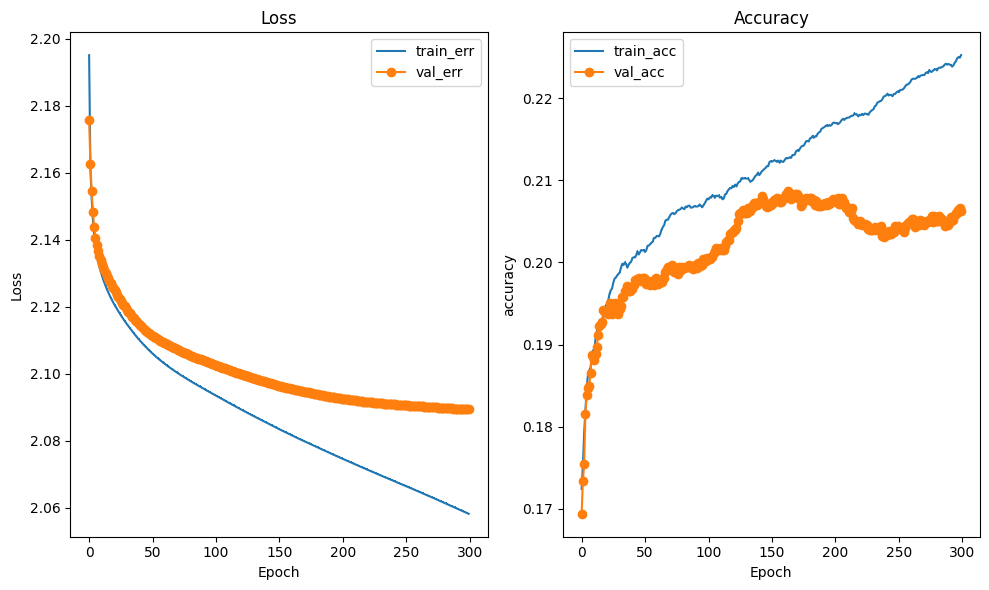

In [28]:
### 학습곡선 (loss)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='train_err', marker = ',')
plt.plot(history['val_loss'], label='val_err', marker = 'o')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Loss')

### 학습곡선 (Accuracy)
plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='train_acc', marker = ',')
plt.plot(history['val_accuracy'], label='val_acc', marker = 'o')

plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()